<a href="https://colab.research.google.com/github/BrunoSeixasBonfati/DetcDefPav/blob/main/detecDefeitoPav_DROPOUT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Função para carregar e pré-processar o conjunto de dados

In [ ]:
def load_data(data_dir, img_size):
    X = []
    y = []
    classes = os.listdir(data_dir)

    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_size, img_size))
            X.append(img)
            y.append(classes.index(class_name))

    X = np.array(X)
    y = np.array(y)
    return X, y

Carregar o conjunto de dados

In [ ]:
data_dir = "/content/drive/MyDrive/CodigoDissertacao/filtered"
img_size = 100
X, y = load_data(data_dir, img_size)

Dividir o conjunto de dados em treinamento e teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Função de oversampling (Sobreamostragem) aumentar o número de amostras das classes que têm menos amostras, para equilibrar a distribuição das classes

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Criar uma instância do RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Reshape os dados de treinamento para terem apenas 2 dimensões
num_samples_train, img_height, img_width, num_channels = X_train.shape
X_train_reshaped = X_train.reshape(num_samples_train, -1)

# Aplicar o oversampling aos seus dados de treinamento
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train_reshaped, y_train)

# Agora X_train_oversampled e y_train_oversampled contêm os dados de treinamento com oversampling

# Voltar ao formato original após o oversampling
X_train_oversampled = X_train_oversampled.reshape(-1, img_height, img_width, num_channels)

Construir o modelo CNN

In [ ]:
# Adicionando mais camadas à rede neural
model = models.Sequential([
layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
layers.MaxPooling2D((2, 2)),
layers.Conv2D(64, (3, 3), activation='relu'),
layers.MaxPooling2D((2, 2)),
layers.Conv2D(128, (3, 3), activation='relu'),  # Nova camada convolucional
layers.Flatten(),
layers.Dense(128, activation='relu'),  # Nova camada densa
layers.Dense(len(np.unique(y)), activation='softmax')
])

# Aumentando o número de neurônios em cada camada
model = models.Sequential([
layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),  # Aumentando para 64 filtros
layers.MaxPooling2D((2, 2)),
layers.Conv2D(128, (3, 3), activation='relu'),  # Aumentando para 128 filtros
layers.MaxPooling2D((2, 2)),
layers.Conv2D(256, (3, 3), activation='relu'),  # Aumentando para 256 filtros
layers.Flatten(),
layers.Dense(256, activation='relu'),  # Aumentando para 256 neurônios
layers.Dense(len(np.unique(y)), activation='softmax')
])

# Experimentando arquiteturas mais complexas
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

model = models.Sequential([
base_model,
layers.Flatten(),
layers.Dense(256, activation='relu'),
layers.Dropout(0.5),
layers.Dense(len(np.unique(y)), activation='softmax')
])

Normalizar os dados de entrada e Aumento de dados

In [ ]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Aumento de dados
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train)

Compilar o modelo

In [ ]:
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Treinar o modelo

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32,
                    epochs=10,
                    validation_data=(X_test, y_test))

Epoch 1/10
13/13 [==============================] - 128s 10s/step - loss: 4.3157 - accuracy: 0.2629 - val_loss: 1.8572 - val_accuracy: 0.3738
Epoch 2/10
13/13 [==============================] - 127s 10s/step - loss: 1.9190 - accuracy: 0.3615 - val_loss: 1.9282 - val_accuracy: 0.3738
Epoch 3/10
13/13 [==============================] - 124s 9s/step - loss: 1.9499 - accuracy: 0.3286 - val_loss: 1.8300 - val_accuracy: 0.3738
Epoch 4/10
13/13 [==============================] - 124s 9s/step - loss: 1.8159 - accuracy: 0.3756 - val_loss: 1.7802 - val_accuracy: 0.3738
Epoch 5/10
13/13 [==============================] - 124s 9s/step - loss: 1.7594 - accuracy: 0.4061 - val_loss: 1.7618 - val_accuracy: 0.4112
Epoch 6/10
13/13 [==============================] - 124s 9s/step - loss: 1.7228 - accuracy: 0.4366 - val_loss: 1.6512 - val_accuracy: 0.4206
Epoch 7/10
13/13 [==============================] - 124s 9s/step - loss: 1.7105 - accuracy: 0.4531 - val_loss: 1.7582 - val_accuracy: 0.3738
Epoch 8/10


Plotar os resultados do treinamento

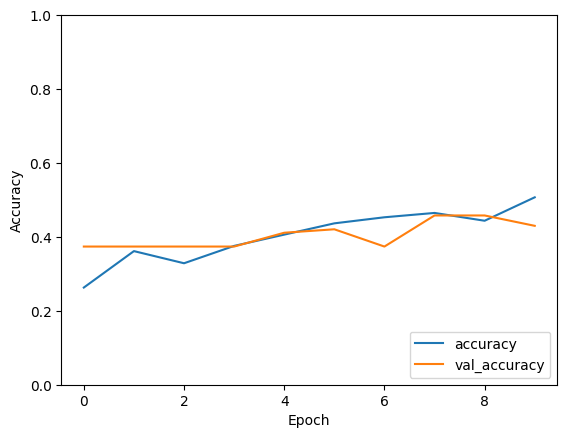

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

Avaliar o modelo no conjunto de teste

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Acurácia no conjunto de teste:", test_acc)

4/4 [==============================] - 7s 2s/step - loss: 1.5726 - accuracy: 0.4299
Acurácia no conjunto de teste: 0.42990654706954956


In [ ]:
from sklearn.metrics import classification_report

# Prever as classes para o conjunto de teste
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerar o relatório de classificação
report = classification_report(y_test, y_pred_classes)

print("Relatório de Classificação:")
print(report)


4/4 [==============================] - 7s 2s/step
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         7
           5       0.36      0.76      0.49        17
           6       0.17      0.40      0.24        15
           7       0.77      0.68      0.72        40

    accuracy                           0.43       107
   macro avg       0.16      0.23      0.18       107
weighted avg       0.37      0.43      0.38       107



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Suponha que você tenha uma lista de nomes de classes
class_folders = os.listdir(data_dir)  # Obtém os nomes das pastas das classes do diretório de dados
class_dict = {i: folder for i, folder in enumerate(class_folders)}  # Cria um dicionário de mapeamento de índice de classe para nome da pasta
class_dict


{0: '4_TrincaTransversal',
 1: '13_Exsudação',
 2: '8_Desgaste',
 3: '14_Remendo',
 4: '5_TrincaLongitudinal',
 5: '1_Buraco',
 6: '3_TrincaPorFadiga',
 7: 'NonCracks'}

In [ ]:
# Contar o número de amostras para a classe em questão no conjunto de treinamento
num_samples_train = np.sum(y_train == 6)

# Contar o número de amostras para a classe em questão no conjunto de teste
num_samples_test = np.sum(y_test == 6)

print("Número de amostras para a classe em questão no conjunto de treinamento:", num_samples_train)
print("Número de amostras para a classe em questão no conjunto de teste:", num_samples_test)


Número de amostras para a classe em questão no conjunto de treinamento: 66
Número de amostras para a classe em questão no conjunto de teste: 9
